# Multi-Criteria Decision Making (MCDM) with CLIMADA

## Introduction to MCDM

**Multi-Criteria Decision Making (MCDM)** is a mathematical framework for evaluating and ranking multiple alternatives based on multiple criteria. It combines **objectives** (e.g., minimizing or maximizing) and **importance weights** to guide decision-making through ranking algorithms.

### Core Steps in MCDM

1. **Define Criteria, Weights, Objectives, and Alternatives**
   - Identify the decision criteria, assign their relative importance, and define the alternatives to evaluate.
   
2. **Normalization**
   - Criteria values are converted to a comparable scale using methods like linear normalization. For example, values are scaled to a 0–1 range, ensuring comparability across different units.

3. **Ranking**
   - Algorithms are applied to rank alternatives, each offering unique strengths for varying decision-making needs:
     - **SAW (Simple Additive Weighting)**: Computes a total score for each alternative by summing weighted criteria scores. Straightforward and intuitive.
     - **TOPSIS (Technique for Order of Preference by Similarity to Ideal Solution)**: Ranks alternatives based on proximity to ideal and worst-case solutions, balancing trade-offs.
     - **VIKOR (VIsekriterijumska optimizacija i KOmpromisno Resenje)**: Similar to TOPSIS but prioritizes minimizing the worst-performing criterion by penalizing closeness to the worst criteria. Ideal for risk-averse decisions.
     - **Compromise Rankings**: Integrates outputs from multiple methods to provide a balanced decision.
     
---
## Using MCDM as a Decision-Making Framework

MCDM goes beyond computation—it provides a framework to guide structured discussions and analysis. Key questions include:
- **What criteria are we considering?**
- **How can we measure these criteria?**
- **How do we value these criteria relative to one another?**

---

## CLIMADA's MCDM Module: Groups, Uncertainty Variables, and Advanced Analysis

The **CLIMADA MCDM Module** provides a structured approach to evaluate alternatives, incorporating criteria performance and decision preferences. By default, the module assumes:
- **Weights**: Equal for all criteria unless specified otherwise.
- **Objectives**: Criteria are maximized unless explicitly set to minimize.
- **Methods**: Includes widely used approaches like SAW, TOPSIS, and VIKOR.

### Groups

Sub-groups can help identify how different alternatives perform across distinct populations. For example, an adaptation measure may appear beneficial on average but perform poorly for one group and exceptionally well for another.

- **Groups**: Represent distinct sub-populations (e.g., socio-economic classes, geographic regions). Analyses can be conducted:
  - **Individually**, to assess each group separately.
  - **Aggregated**, combining group-specific criteria into composite measures.

### Uncertainty Variables

Criteria values may depend on underlying stochastic factors or scenarios, such as future conditions or model uncertainties.

- **Uncertainty Variables**: Represent stochastic or scenario-driven factors (e.g., climate projections, economic changes). These affect criteria values, enabling sensitivity analyses and scenario-based decision-making.

### Key Considerations in MCDM Analysis

| **Consideration**       | **Example**                              | **Approach**                                   |
|--------------------------|------------------------------------------|-----------------------------------------------|
| **Constraints**          | Budget, Regulations                     | Filter out non-satisfactory alternatives      |
| **Uncertainties**        | Future scenarios, criteria variability   | Rank probability distributions, Evaluate scenarios |
| **Groups**               | Socio-economic, Regions, Species        | Assess groups individually or aggregate their criteria |
| **Preferences**          | Risk tolerance, People vs Assets, Stakeholder input | Weight sensitivity, Weighted aggregation, Prioritization (e.g., AHP) |
| **Pareto-optimality**    | Conflicting criteria (e.g., Cost vs Speed)  | Identify Pareto-optimal alternatives, Explore trade-offs |

### Communicating Results Effectively

Clear communication of MCDM results is essential. By visualizing trade-offs, presenting criteria weights, and offering transparent reasoning, decision-makers can foster trust and engagement among stakeholders.

---


## 1. Default Ranking 

We begin by making a simple bike example and make a straightforward ranking based on equal weighting and the default MCDM methods.

### 1.1 - Define the data frame 

In [1]:
import tabulate as tb
import pandas as pd
import numpy as np

# Define the data with more similar values
data = {
    "Design (# friends approve)": [3, 4, 2, 5, 3, 2],  
    "Max Speed (km/h)": [30, 40, 45, 35, 25, 20],  
    "Comfort (Minutes until pain)": [60, 45, 50, 40, 35, 30], 
    "Durability (Years)": [5, 4, 6, 5, 4, 3] 
}

# Create the DataFrame
metrics_df = pd.DataFrame(data)

# Display the DataFrame as tabular data
print('The DataFrame as tabular data:')
print(tb.tabulate(metrics_df, headers='keys', tablefmt='pretty'))


The DataFrame as tabular data:
+---+----------------------------+------------------+------------------------------+--------------------+
|   | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) |
+---+----------------------------+------------------+------------------------------+--------------------+
| 0 |             3              |        30        |              60              |         5          |
| 1 |             4              |        40        |              45              |         4          |
| 2 |             2              |        45        |              50              |         6          |
| 3 |             5              |        35        |              40              |         5          |
| 4 |             3              |        25        |              35              |         4          |
| 5 |             2              |        20        |              30              |         3          |
+---+----------

### 1.1 - Define the Decision Matrix and rank

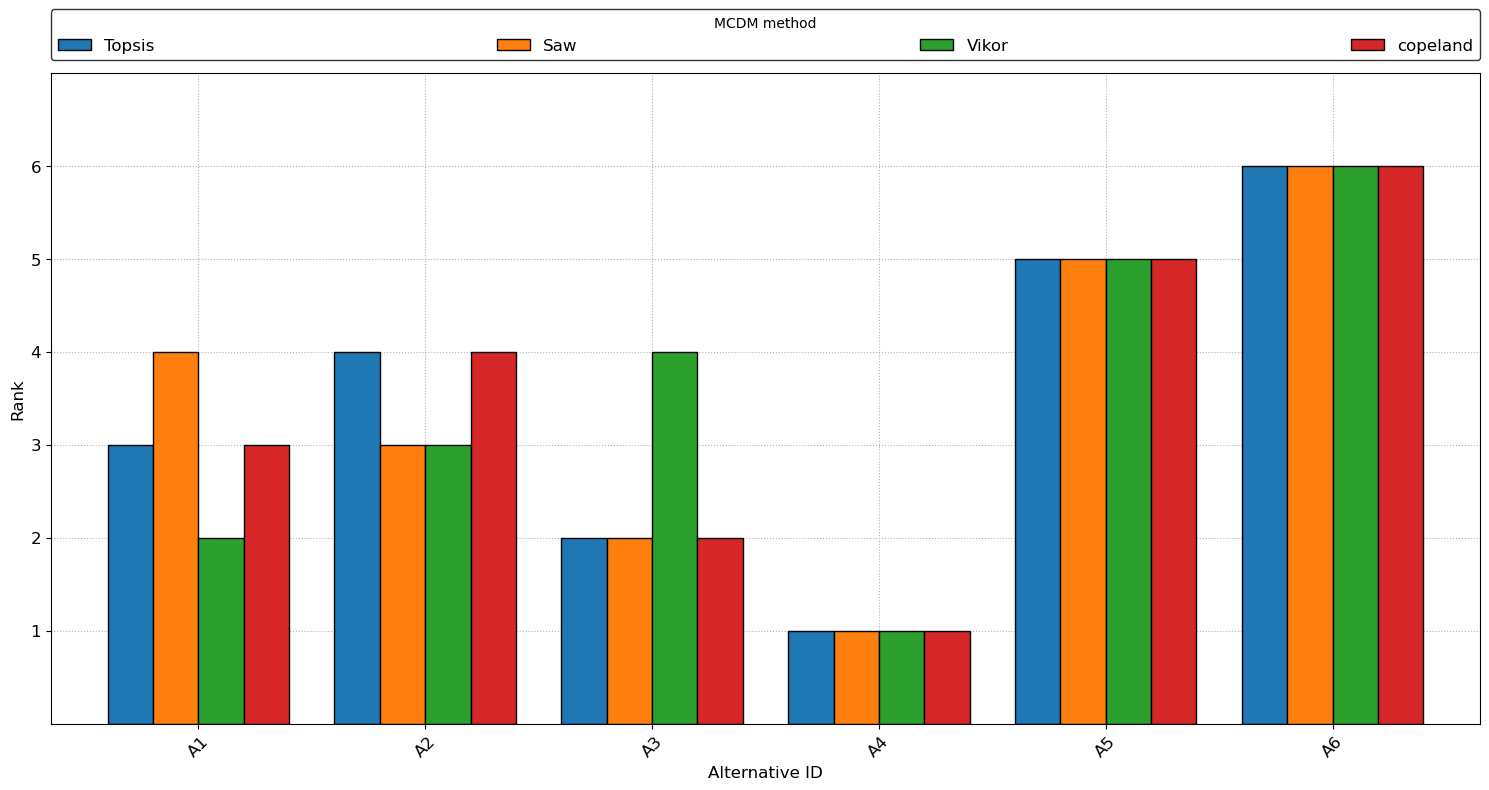

In [2]:
#from MCDM.DecisionMatrix import DecisionMatrix  # Import DecisionMatrix module
from MCDM.MCDM_dev import DecisionMatrix

# Create the DecisionMatrix object
dm = DecisionMatrix(metrics_df=metrics_df)

# Rank the alternatives (results are stored in the RanksOutput object)
ranks_output = dm.calc_rankings()

# Display the rankings
ranks_output.plot_ranks()


The compromised approach points to A2. 

- However, is it clear why the following bikes were ranked in this order? 
- How can we support the decision-maker in understanding why this ranking was achieved?

Furtermore, when using a Multi-Criteria Decision-Making (MCDM) framework, decision-makers often face additional questions to ensure confidence in their choices and effectively communicate decisions. For example:
- "How can we fairly incorporate multiple stakeholders' preferences?"
- "What if the chosen alternative performs poorly under the worst-case scenario?"

This will be explored in the following chapters.


## 2 Analytical Approach: Weights, Criteria Categories, Constraints, and Pareto Optimality

Begin by adding some additional data to data frame

In [3]:
# Add bike names and cost for better context
metrics_df.insert(0, "Bike", ["Urban Commuter", "Mountain Rider", "Speed Racer", "Eco-Friendly", "Classic Cruiser", "Hipster Fixie"]) if "Bike" not in metrics_df.columns else None
metrics_df.insert(1, 'Cost (CHF)', [120, 400, 700, 500, 300, 250]) if 'Cost (CHF)' not in metrics_df.columns else None

# Display the DataFrame with updated values
print('The DataFrame with updated values:')
print(tb.tabulate(metrics_df, headers='keys', tablefmt='pretty'))

The DataFrame with updated values:
+---+-----------------+------------+----------------------------+------------------+------------------------------+--------------------+
|   |      Bike       | Cost (CHF) | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) |
+---+-----------------+------------+----------------------------+------------------+------------------------------+--------------------+
| 0 | Urban Commuter  |    120     |             3              |        30        |              60              |         5          |
| 1 | Mountain Rider  |    400     |             4              |        40        |              45              |         4          |
| 2 |   Speed Racer   |    700     |             2              |        45        |              50              |         6          |
| 3 |  Eco-Friendly   |    500     |             5              |        35        |              40              |         5          |
| 4 | 

### 2.1 - Define the Decision Matrix Object and View the Attributes

We can also add *criteria categories*, which is a way to cluster criteria. This will be useful for plotting and conducting weight sensitivity analysis later, as different criteria may represent metrics of a broader category.


In [4]:
# Parameters
dm_params = {
    "metrics_df": metrics_df, # The DataFrame with the metrics
    "alt_cols": ['Bike'], # Determine which columns are alternatives (mandatory in this case since criteria columsn must be numeric)
    "objectives": { "Cost (CHF)": -1 }, # Minimize, since the default is to maximize
    "crit_cats": {"Vanity": ["Design (# friends approve)", "Max Speed (km/h)"], 
                  "Practicality": ["Cost (CHF)", "Durability (Years)"]} # Define categories for the criteria (optional, but helps with organization)
    
}

# Create the DecisionMatrix object
dm = DecisionMatrix(**dm_params)

# Display the attributes of the DecisionMatrix object (these are structured to help with the organization of the MCDM process)
dm.print_dm()

Decision Matrix:
+---+----------------+-----------------+------------+----------------------------+------------------+------------------------------+--------------------+
|   | Alternative ID |      Bike       | Cost (CHF) | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) |
+---+----------------+-----------------+------------+----------------------------+------------------+------------------------------+--------------------+
| 0 |       A1       | Classic Cruiser |    300     |             3              |        25        |              35              |         4          |
| 1 |       A2       |  Eco-Friendly   |    500     |             5              |        35        |              40              |         5          |
| 2 |       A3       |  Hipster Fixie  |    250     |             2              |        20        |              30              |         3          |
| 3 |       A4       | Mountain Rider  |    400     |      

### 2.2 Compare Overall Criteria Performance

- **Overview**: Evaluate how each alternative performs across all criteria.

#### 2.2.1 Ranking Based on *Criteria Values* (Pre-MCDM Scores)

- **Key Question**: Is any alternative clearly performing best across all criteria?

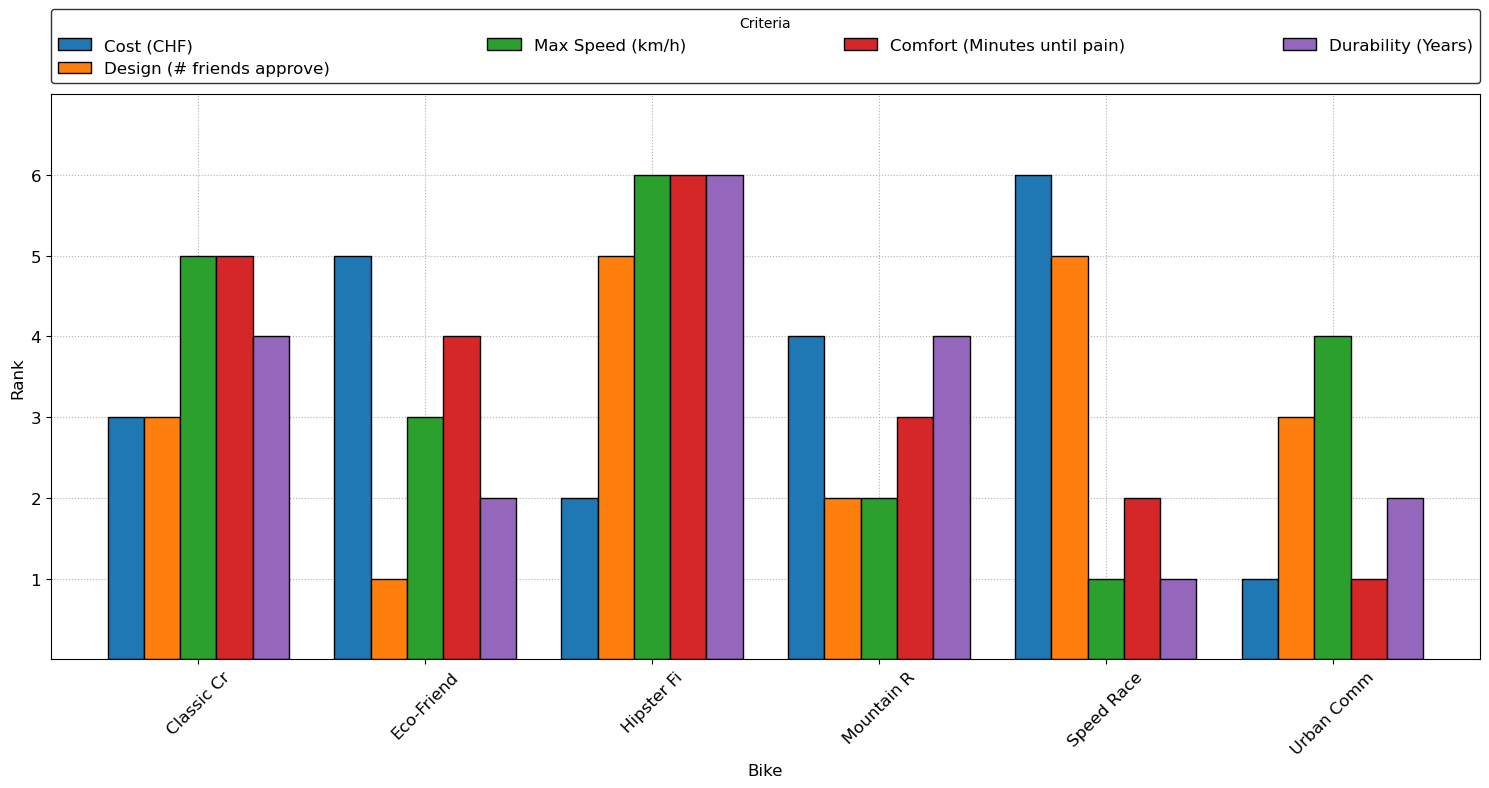

In [5]:
dm.calc_rankings().plot_ranks(rank_type='criteria') # Plot the rankings based on the criteria not the MCDM rankings

#### 2.2.2 Plotting Normalized Criteria Values

- **Key Question**: Is the performance of each criterion evenly distributed across alternatives, or do some alternatives perform exceptionally well in certain criteria while performing poorly in others?

Normalization can also help users understand the performance across each criterion, e.g., a 1–5 scale (where 5 is best). Additional criteria, based on qualitative surveys, can also be added to match the scale.

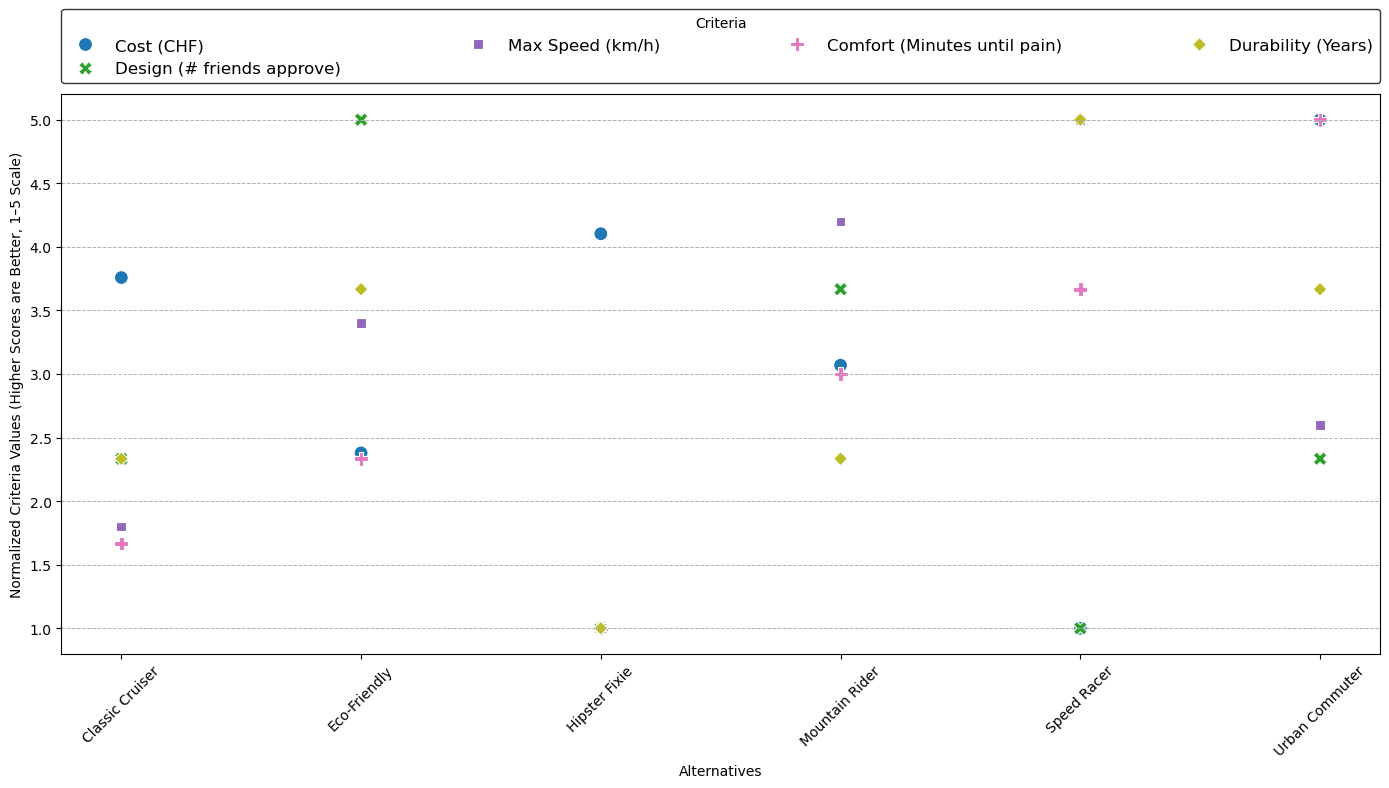

The normalized DataFrame as tabular data:
+---+----------------+-----------------+--------------------+----------------------------+--------------------+------------------------------+--------------------+----------+-----------+
|   | Alternative ID |      Bike       |     Cost (CHF)     | Design (# friends approve) |  Max Speed (km/h)  | Comfort (Minutes until pain) | Durability (Years) | Group ID | Sample ID |
+---+----------------+-----------------+--------------------+----------------------------+--------------------+------------------------------+--------------------+----------+-----------+
| 0 |       A1       | Classic Cruiser | 3.7586205060047857 |     2.3333203093709587     | 1.8000005846595757 |      1.6666663217890747      | 2.3333416043606796 |    G1    |    S1     |
| 1 |       A2       |  Eco-Friendly   | 2.3793101154991385 |            5.0             | 3.4000060815376614 |      2.3333303256311293      | 3.6666457623444138 |    G1    |    S1     |
| 2 |       A3       | 

In [6]:
# Plot the normalized decision matrix
norm_df = dm.process_and_plot_norm_criteria(scale_to=5) # Default is to scale from 0 to 1

# Display the normalized DataFrame as tabular data
print('The normalized DataFrame as tabular data:')
print(tb.tabulate(norm_df, headers='keys', tablefmt='pretty'))

### 2.3 Investigate Trade-offs, Dominance and Pareto Optimality

- **Key Question**: What is the best we can achieve in one criterion before compromising on others?

- **Definitions**:
    - **Dominance**: An alternative dominates another if it is at least as good in all criteria and strictly better in at least one.  
    - **Pareto Optimality**: A solution is Pareto optimal if it is not dominated by any other alternative.  
    - **Pareto Frontier**: The Pareto frontier represents the set of all Pareto optimal solutions, highlighting the best trade-offs across criteria and forming a boundary beyond which no improvements can be made without compromise.

+---+-----------------+------------+----------------------------+------------------+------------------------------+--------------------+----------------------------------------------------------------------+----------------+----------------+
|   |      Bike       | Cost (CHF) | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) |                             Dominated By                             | Dominance Rank | Pareto Optimal |
+---+-----------------+------------+----------------------------+------------------+------------------------------+--------------------+----------------------------------------------------------------------+----------------+----------------+
| 0 | Classic Cruiser |    300     |             3              |        25        |              35              |         4          |                  ['Eco-Friendly', 'Mountain Rider']                  |       2        |     False      |
| 1 |  Eco-Friendly   |    500  

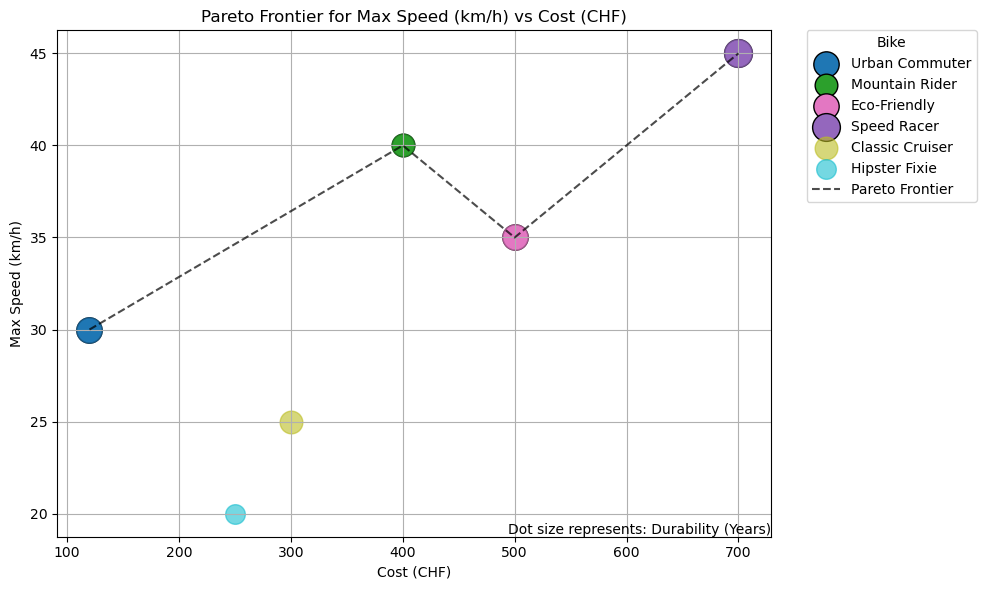

In [7]:
# Analyze dominance and Pareto optimality for the subset
dominance_pareto_df, criteria_comparison_df = dm.analyze_dominance_and_pareto() # The criteria_comparison_df stores the performance of each alternative in relation to the others (no need to display it here)

# Display results
print(tb.tabulate(dominance_pareto_df, headers='keys', tablefmt='pretty'))

# With size determined by 'Durability (Years)' and lines between points
dm.plot_pareto_frontier(
    criteria_x='Cost (CHF)', 
    criteria_y='Max Speed (km/h)', 
    criteria_z='Durability (Years)'
)

### 2.4 Constraints

- **Key Question**: How can we exclude alternatives that do not meet certain baseline requirements before scoring and ranking?

Constraints allow the user to filter out alternatives that do not satisfy specific conditions. 

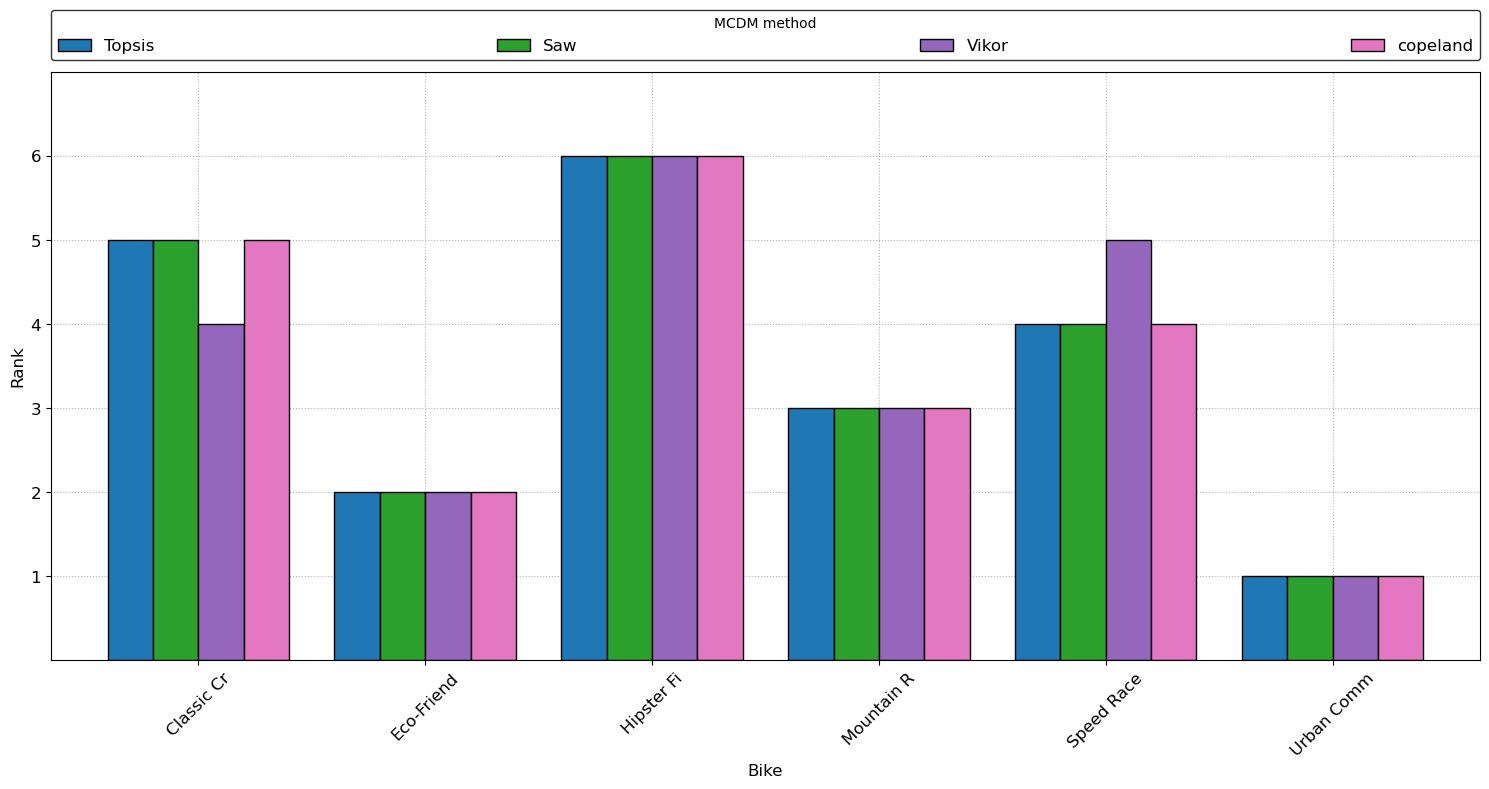

Table below shows the excluded alternatives, i.e., not satifying constraints,
where True if particular constraint is satisfied and False if not. 
.
.
+------------------+--------+--------------+----------------------+
| Alternative ID   | Bike   | Cost (CHF)   | Durability (Years)   |
|------------------+--------+--------------+----------------------|
+------------------+--------+--------------+----------------------+


In [8]:
from tabulate import tabulate

# Add constraints to the ranking parameters (you can also exclude non-pareto optimal alternatives, see calc_rankings docstring)
rank_params = {
    "constraints": {"Cost (CHF)": {'less': 900}, 
                    "Durability (Years)": {'greater': 1}},
}

# Calculate the rankings with the constraints
dm.calc_rankings(**rank_params).plot_ranks()

# Print the alternatives that do not satisfy the constraints
print("Table below shows the excluded alternatives, i.e., not satifying constraints,\nwhere True if particular constraint is satisfied and False if not.", 2*"\n.")
print(tabulate(dm.calc_rankings(**rank_params).alt_exc_const_df, headers='keys', tablefmt='psql'))



### 2.5 Preferences - Weights, Weight Helpers, Weight Sensitivity, and MCDM Methods

- **Key Question**: How do we incorporate user preferences to reflect the relative importance of criteria and rank alternatives effectively?

Preferences are central to **Multi-Criteria Decision Making (MCDM)**, and they are expressed through **weights**. These weights represent the relative importance of each criterion and play a pivotal role in determining the final ranking of alternatives. To facilitate this, we provide intuitive tools to help users assign weights systematically and pair them with various **MCDM methods** for effective decision-making.

### 2.5.1 - Weight Helpers

- **Key Question**: How can we simplify the process of assigning weights to ensure that user preferences are accurately captured?

Weights in MCDM represent the **relative importance** of each criterion, and the total weight must sum to **1**. While the concept is simple, assigning weights can be challenging when dealing with multiple criteria. 

To address this, we offer **helper functions** that guide users through the weight assignment process:

- **Importance Scale**: Assign a scale (e.g., 1–5) to criteria and normalize the scores to derive the weights.
- **Analytical Hierarchy Process (AHP)**: A structured approach involving pairwise comparisons to derive weights systematically.
- **Categorical Weights**: Group criteria into categories, simplifying the process by assigning weights to groups rather than individual criteria.

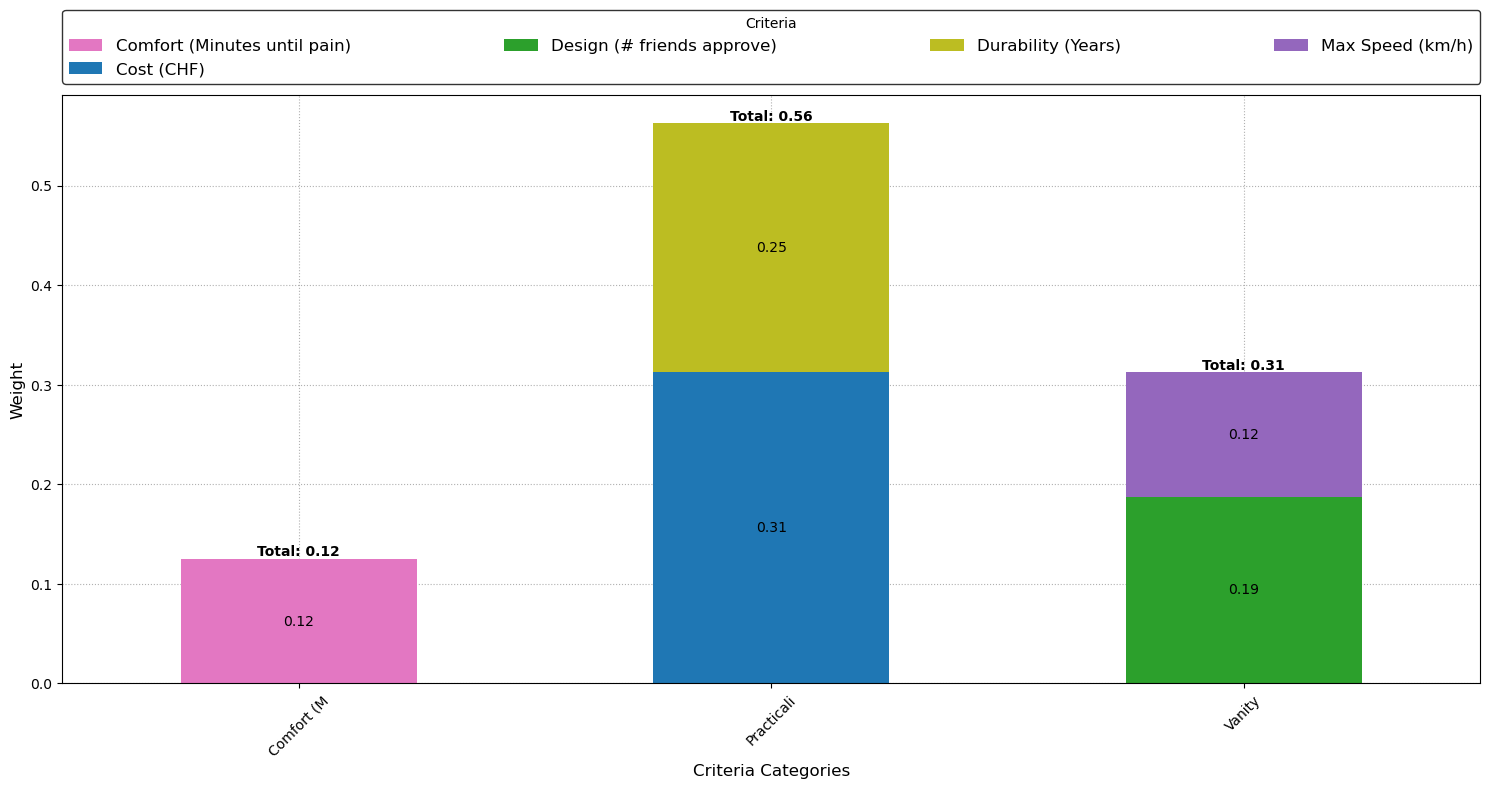

In [9]:
from MCDM.utils.weights_helpers_utils import weight_from_scale, weight_from_ahp, weight_from_categories

# Set the importance of the criteria as a scale (1 to 5 is default)
criteria_scale = { "Cost (CHF)": 5, "Durability (Years)": 4, "Design (# friends approve)": 3, "Max Speed (km/h)": 2, "Comfort (Minutes until pain)": 2}
weights = weight_from_scale(criteria_scale)

# Lets create a new DecisionMatrix object with the weights and display the weights
dm_params["weights"] = weights
dm = DecisionMatrix(**dm_params)

# Display the weights
dm.plot_criteria_weights()

You can also do this manually based on the available helpers (uncomment the code below).

In [10]:
from MCDM.utils.weights_helpers_utils import manual_input_weights

# manual_input_weights(list(dm.crit_df['Criteria'].values), 
#                      method= 'pairwise')

### 2.5.2 - Weight Sensitivity

- **Key Question**: How sensitive are the rankings of alternatives to changes in the assigned weights? For users with a strong bias toward one criterion or a specific group of criteria, how does the ranking change as preferences shift?


Analyzing sensitivity for: Vanity: ['Design (# friends approve)', 'Max Speed (km/h)']


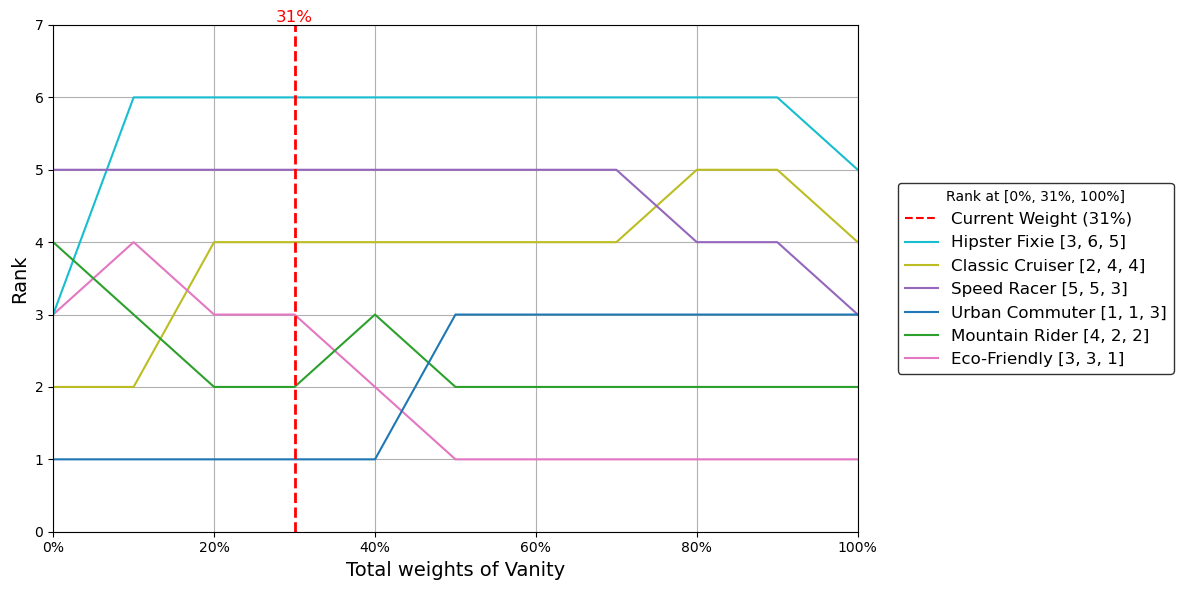

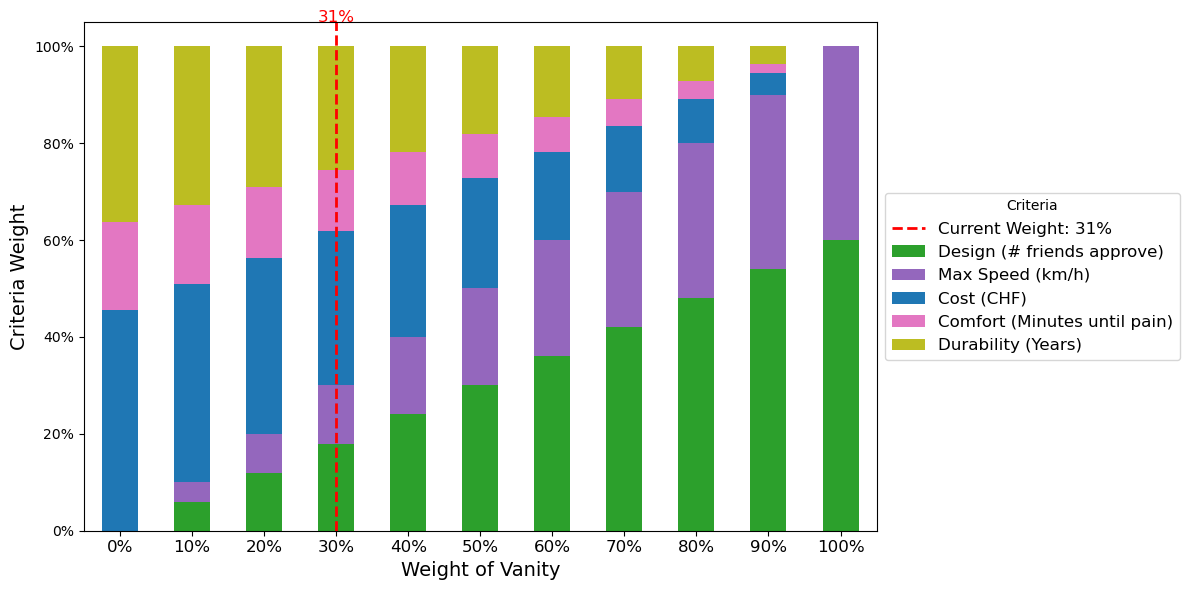

Analyzing sensitivity for: Practicality: ['Cost (CHF)', 'Durability (Years)']


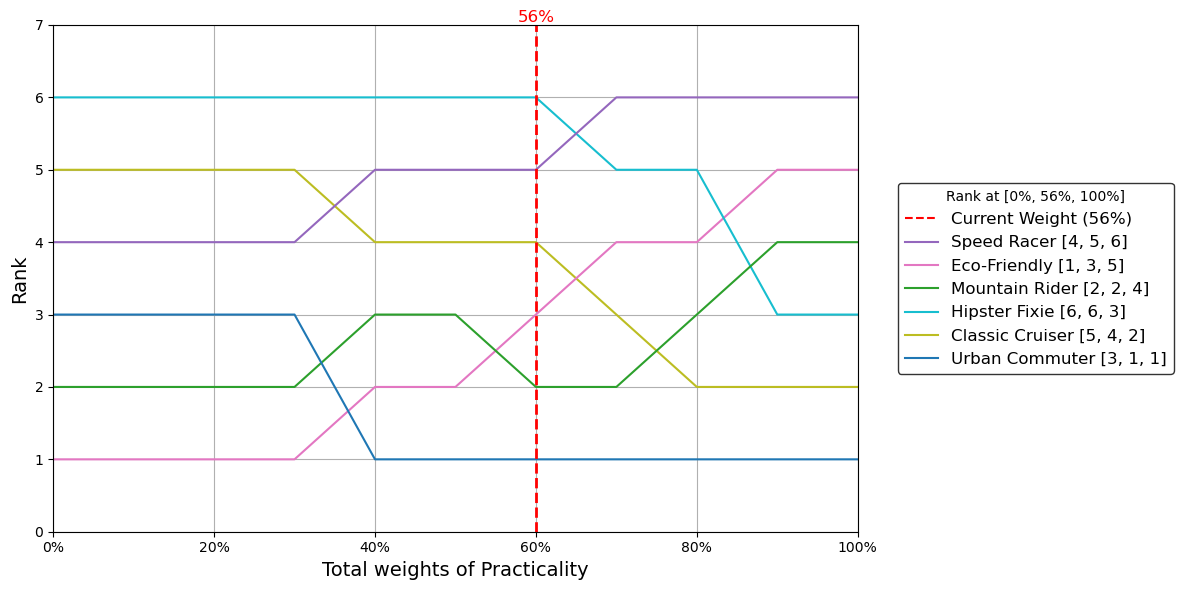

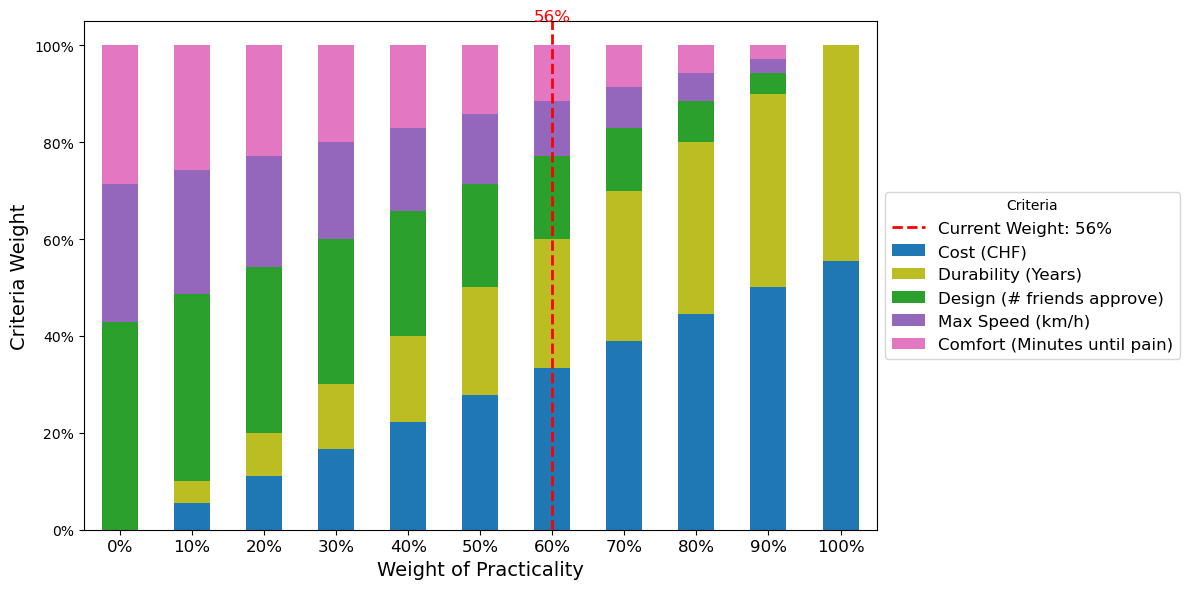

Analyzing sensitivity for: Comfort (Minutes until pain): ['Comfort (Minutes until pain)']


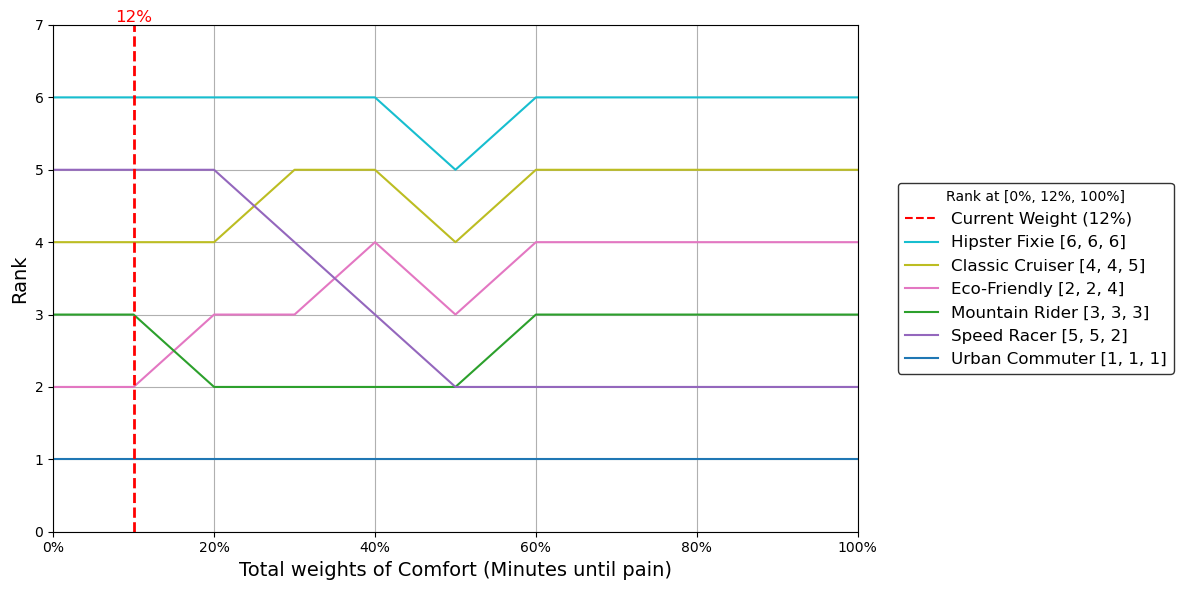

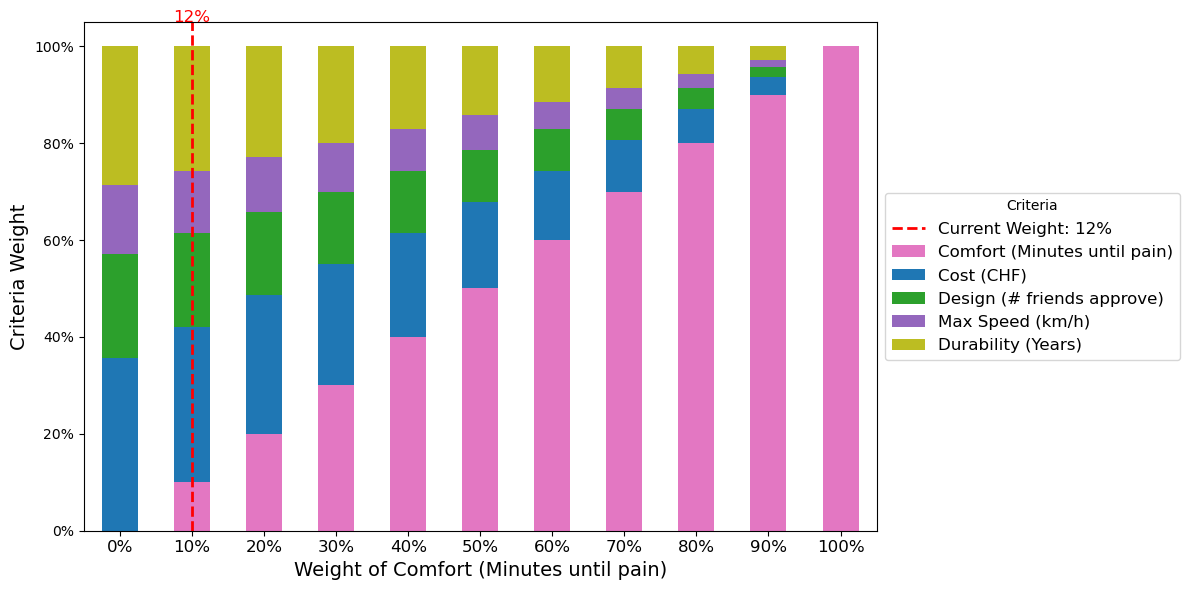

In [11]:
_ = dm.analyse_sens_weights(**rank_params) # Analyse the sensitivity of the weights (default is to do it on the criteria categories)

### 2.5.3 - Combining Weights

- **Key Question**: For a final decision involving multiple stakeholders, how can we incorporate their individual preferences into a combined, mutually agreed weighting scheme?

Combined Weights: {'Cost (CHF)': 0.35, 'Design (# friends approve)': 0.15000000000000002, 'Max Speed (km/h)': 0.15000000000000002, 'Comfort (Minutes until pain)': 0.25, 'Durability (Years)': 0.1}


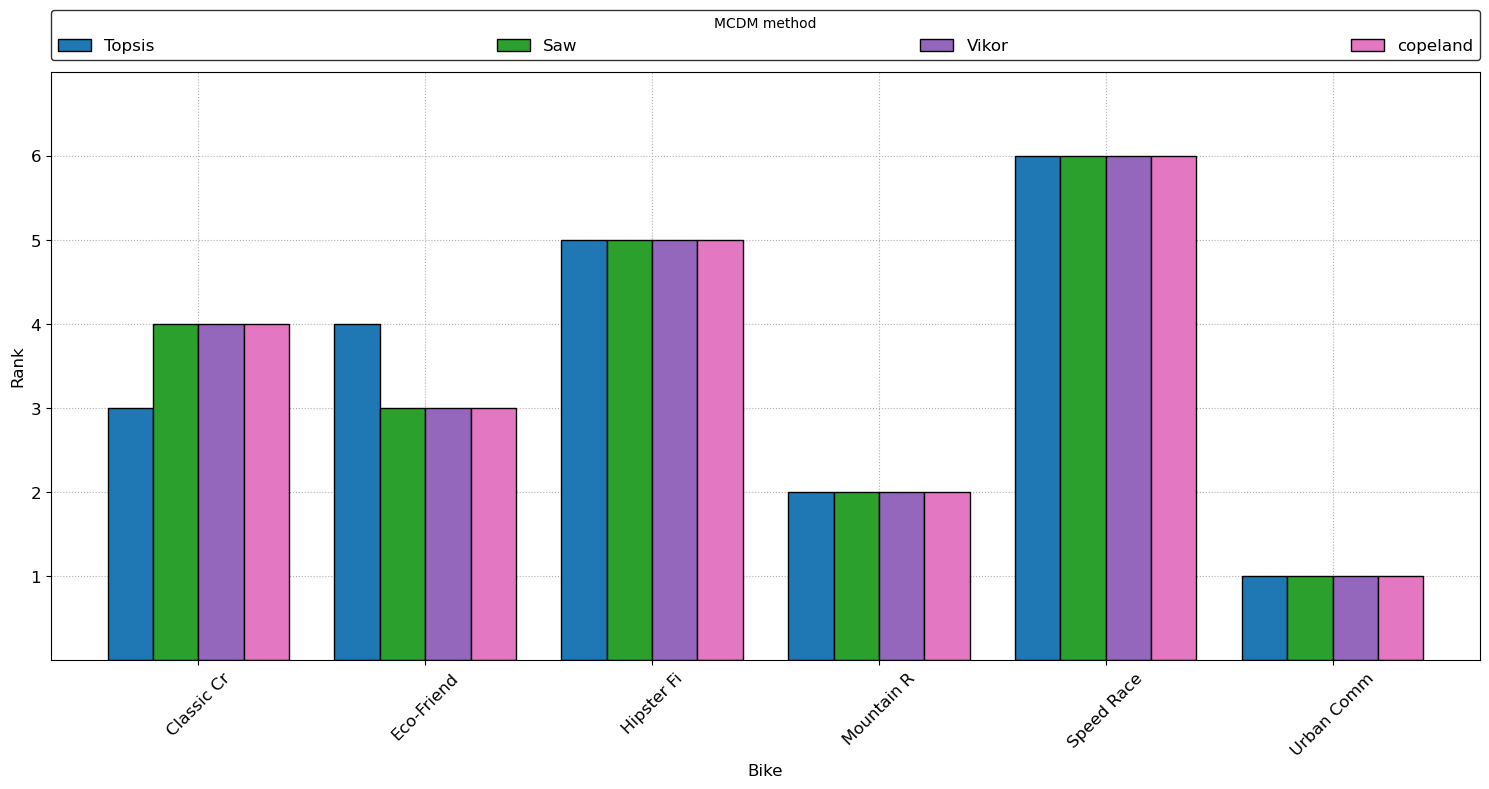

In [12]:
# Alex's and Taylor's weights
weights_alex = {"Cost (CHF)": 0.4, "Design (# friends approve)": 0.2, "Max Speed (km/h)": 0.1, "Comfort (Minutes until pain)": 0.2, "Durability (Years)": 0.1}
weights_taylor = {"Cost (CHF)": 0.3, "Design (# friends approve)": 0.1, "Max Speed (km/h)": 0.2, "Comfort (Minutes until pain)": 0.3, "Durability (Years)": 0.1}

# Combine the weights by averaging (equal vote assumption)
combined_weights = {key: (weights_alex[key] + weights_taylor[key]) / 2 for key in weights_alex}
print("Combined Weights:", combined_weights)

# Create a new DecisionMatrix object with the combined weights
dm_params["weights"] = combined_weights

# Create the DecisionMatrix object with the combined weights and rank the alternatives
DecisionMatrix(**dm_params).calc_rankings(**rank_params).plot_ranks()

## 3. Accounting for Groups: Fairness and Impact in Decision-Making

In many decision-making scenarios, it’s crucial to evaluate how alternatives perform across distinct groups rather than relying solely on aggregated averages. Aggregating criteria into a single average can mask disparities—some alternatives may excel for one group but perform poorly for another.

MCDM provides tools to analyze group dynamics effectively by focusing on the **relative performance** within each criterion. Two primary approaches can be applied:

1. **Individual Group Analysis**:  
   Evaluate criteria performance for each group independently to uncover disparities, trade-offs, or group-specific advantages.

2. **Composite Criteria Construction**:  
   Combine group-specific performances into new criteria, reflecting an overall balance or the weighted importance of group preferences.

You can also treat groups as **information sources**. For example, in the table below, each group represents criteria values derived from two sources: "Tested" and "Reviews." By assigning different **internal weights** to these sources, you can adjust their influence in the decision-making process.


In [13]:
# Updated Data before pivoting
data = {
    "Bike": [
        "Urban Commuter", "Urban Commuter",
        "Mountain Rider", "Mountain Rider",
        "Speed Racer", "Speed Racer",
        "Eco-Friendly", "Eco-Friendly",
        "Classic Cruiser", "Classic Cruiser",
        "Hipster Fixie", "Hipster Fixie",
    ],
    "Source": ["Tested", "Reviews"] * 6,
    "Cost (CHF)": [120, 120, 400, 400, 700, 700, 500, 500, 300, 300, 250, 250],
    "Design (# friends approve)": [3, 3, 4, 4, 2, 2, 5, 5, 3, 3, 2, 2],
    "Max Speed (km/h)": [30.0, 31.0, 40.0, 41.0, 45.0, 46.0, 35.0, 36.0, 25.0, 26.0, 20.0, 21.0],
    "Comfort (Minutes until pain)": [60, 61, 45, 46, 50, 51, 40, 41, 35, 36, 30, 31],
    "Durability (Years)": [5, 5, 4, 4, 6, 6, 5, 5, 4, 4, 3, 3],
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame as tabular data
print("The DataFrame as tabular data:")
print(tb.tabulate(df, headers="keys", tablefmt="pretty"))


The DataFrame as tabular data:
+----+-----------------+---------+------------+----------------------------+------------------+------------------------------+--------------------+
|    |      Bike       | Source  | Cost (CHF) | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) |
+----+-----------------+---------+------------+----------------------------+------------------+------------------------------+--------------------+
| 0  | Urban Commuter  | Tested  |    120     |             3              |       30.0       |              60              |         5          |
| 1  | Urban Commuter  | Reviews |    120     |             3              |       31.0       |              61              |         5          |
| 2  | Mountain Rider  | Tested  |    400     |             4              |       40.0       |              45              |         4          |
| 3  | Mountain Rider  | Reviews |    400     |             4              |     

3.1 - Define the decision matrix ans specify the groups

In [14]:
# Create the DecisionMatrix object
dm_params["metrics_df"] = df
dm_params["group_cols"] = ["Source"]
dm_params["group_weights"] = {"Source": {"Tested": 0.4, "Reviews": 0.6}} # Assign different internal weights to the groups (default is equal weights)

# Create the DecisionMatrix object
dm_groups = DecisionMatrix(**dm_params)

# Print the rankings 
dm_groups.calc_rankings(**rank_params).print_rankings()


Group: G1
-----------------------------------
+------------------+-----------------+----------+----------+-------+---------+------------+
| Alternative ID   | Bike            | Source   |   Topsis |   Saw |   Vikor |   copeland |
|------------------+-----------------+----------+----------+-------+---------+------------|
| A1               | Classic Cruiser | Reviews  |        3 |     4 |       4 |          4 |
| A2               | Eco-Friendly    | Reviews  |        4 |     3 |       3 |          3 |
| A3               | Hipster Fixie   | Reviews  |        5 |     5 |       5 |          5 |
| A4               | Mountain Rider  | Reviews  |        2 |     2 |       2 |          2 |
| A5               | Speed Racer     | Reviews  |        6 |     6 |       6 |          6 |
| A6               | Urban Commuter  | Reviews  |        1 |     1 |       1 |          1 |
+------------------+-----------------+----------+----------+-------+---------+------------+


Group: G2
----------------------

Perfrom a pivot to create the new criteria and picot

Cost (CHF): All columns have the same values. Retain the original name.
Design (# friends approve): All columns have the same values. Retain the original name.
Max Speed (km/h): Columns have different values. Reweight and introduce new criteria.
Comfort (Minutes until pain): Columns have different values. Reweight and introduce new criteria.
Durability (Years): All columns have the same values. Retain the original name.


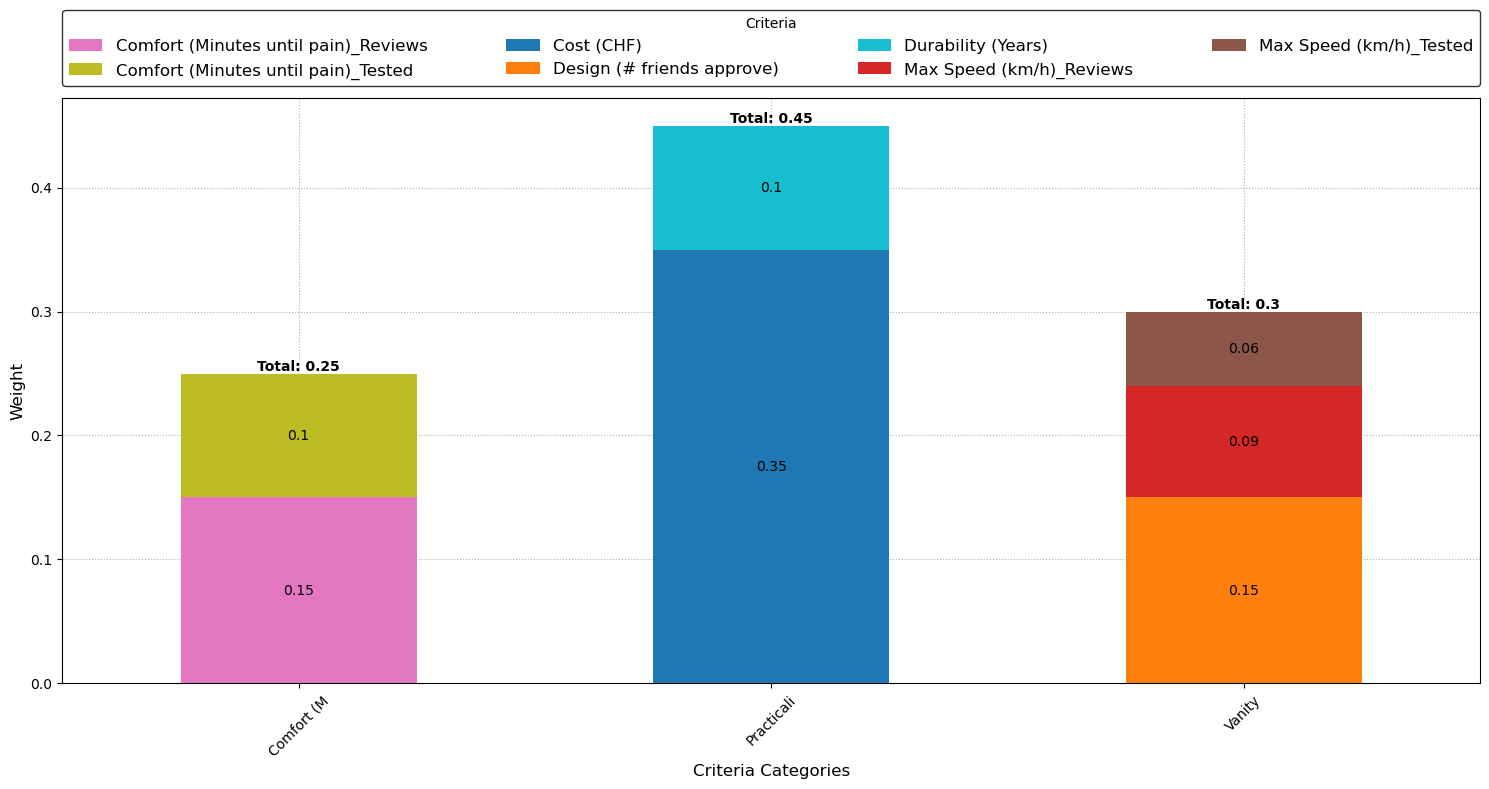

In [15]:
# Pivot and reweight the criteria
dm_groups = dm_groups.pivot_and_reweight_criteria(piv_col= "Source")

# Plot the criteria weights
dm_groups.plot_criteria_weights()

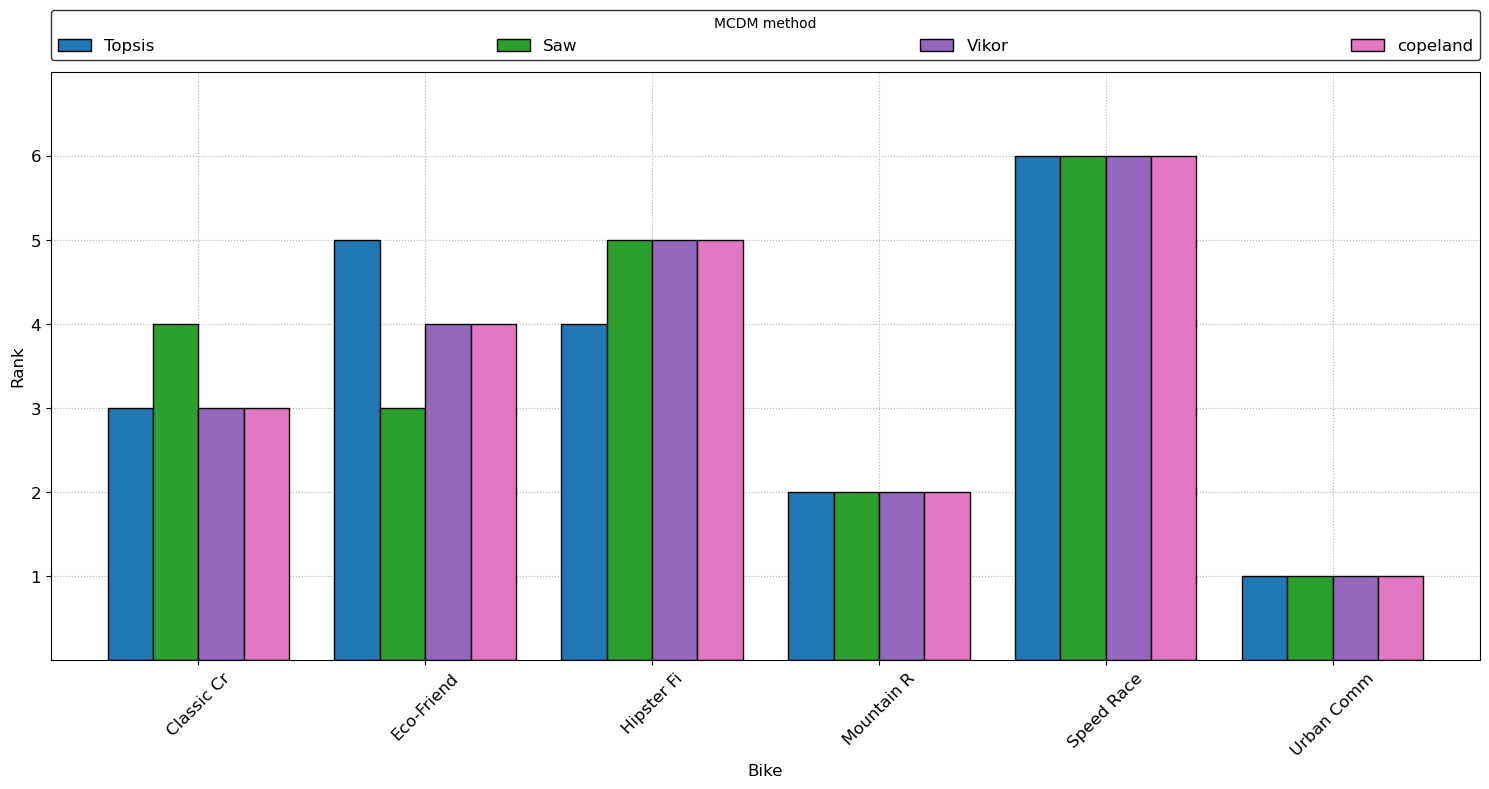

In [16]:
# Rank the alternatives
dm_groups.calc_rankings(**rank_params).plot_ranks()

### 4. Uncertainty Variables: Incorporating Uncertainty in MCDM

In MCDM, criteria values often depend on underlying stochastic factors or scenario-based variations, introducing **uncertainties** into the decision-making process. These uncertainties can stem from, for example:

- **Future Scenarios**: Variations in criteria performance based on different climate projections, socio-economic pathways, or policy scenarios.
- **Model Variability**: Changes in criteria values due to uncertainties in the inputs or parameters used for their computation.

#### Handling Uncertainty in MCDM

1. **Scenario-Based Analysis**:  
   Explore alternative futures by evaluating how criteria perform under different scenarios (e.g., SSP pathways, economic projections).

2. **Stochastic Evaluation**:  
   Incorporate variability in criteria values, allowing for analyses of confidence intervals or distributions across alternatives.


In [17]:
import numpy as np

# Define uncertainty variables: SSP Level and Future Location
scenarios = pd.DataFrame(
    [(ssp, loc) for ssp in ["SSP1", "SSP5"] for loc in ["Urban", "Rural"]],
    columns=["SSP Level", "Future Location"]
)

# Create the complete DataFrame with all scenario combinations
df = pd.DataFrame(data).merge(scenarios, how="cross")

# Apply scenario-based effects with positive constraints
np.random.seed(42)  # For reproducibility

# Adjust Durability (Years)
df["Durability (Years)"] += np.random.uniform(-2, 2, len(df)) + (df["SSP Level"] == "SSP1").astype(int) * 1
df["Durability (Years)"] = df["Durability (Years)"].clip(lower=0.1)  # Ensure positive values

# Adjust Comfort (Minutes until pain)
df["Comfort (Minutes until pain)"] += np.random.uniform(-5, 5, len(df)) + (df["Future Location"] == "Urban").astype(int) * -3
df["Comfort (Minutes until pain)"] = df["Comfort (Minutes until pain)"].clip(lower=1)  # Ensure positive values

# Adjust Max Speed (km/h)
df["Max Speed (km/h)"] += np.random.uniform(-4, 4, len(df)) + (df["SSP Level"] == "SSP5").astype(int) * 2
df["Max Speed (km/h)"] = df["Max Speed (km/h)"].clip(lower=0.1)  # Ensure positive values

# Round numerical columns for readability
df[["Durability (Years)", "Comfort (Minutes until pain)", "Max Speed (km/h)"]] = df[
    ["Durability (Years)", "Comfort (Minutes until pain)", "Max Speed (km/h)"]
].round(1)

# Display the resulting DataFrame
print('The DataFrame with SSP Level and Future Location effects (ensuring positive minimums):')
print(tb.tabulate(df, headers='keys', tablefmt='pretty'))


The DataFrame with SSP Level and Future Location effects (ensuring positive minimums):
+----+-----------------+---------+------------+----------------------------+------------------+------------------------------+--------------------+-----------+-----------------+
|    |      Bike       | Source  | Cost (CHF) | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) | SSP Level | Future Location |
+----+-----------------+---------+------------+----------------------------+------------------+------------------------------+--------------------+-----------+-----------------+
| 0  | Urban Commuter  | Tested  |    120     |             3              |       30.2       |             57.5             |        5.5         |   SSP1    |      Urban      |
| 1  | Urban Commuter  | Tested  |    120     |             3              |       29.4       |             56.8             |        7.8         |   SSP1    |      Rural      |
| 2  | Urban Commuter  

In [18]:
# Define parameters
dm_params["metrics_df"] = df # The DataFrame with the metrics
dm_params["unc_cols"] = ["SSP Level", "Future Location"] # Define the uncertainty columns

# Create the DecisionMatrix object
dm_unc = DecisionMatrix(**dm_params)

# Display the attributes of the DecisionMatrix object
dm_unc.print_dm()


Decision Matrix:
+----+----------------+-----------------+----------+---------+-----------+-----------+-----------------+------------+----------------------------+------------------+------------------------------+--------------------+
|    | Alternative ID |      Bike       | Group ID | Source  | Sample ID | SSP Level | Future Location | Cost (CHF) | Design (# friends approve) | Max Speed (km/h) | Comfort (Minutes until pain) | Durability (Years) |
+----+----------------+-----------------+----------+---------+-----------+-----------+-----------------+------------+----------------------------+------------------+------------------------------+--------------------+
| 0  |       A1       | Classic Cruiser |    G1    | Reviews |    S1     |   SSP1    |      Rural      |    300     |             3              |       24.7       |             34.3             |        3.4         |
| 1  |       A1       | Classic Cruiser |    G1    | Reviews |    S2     |   SSP1    |      Urban      |    300

#### 4.1 Plotting Normalized Criteria Values

Lot of data so we could again use the normalized value plot to see the perfromace distribution . Do you now see how the performance starts to overlap 

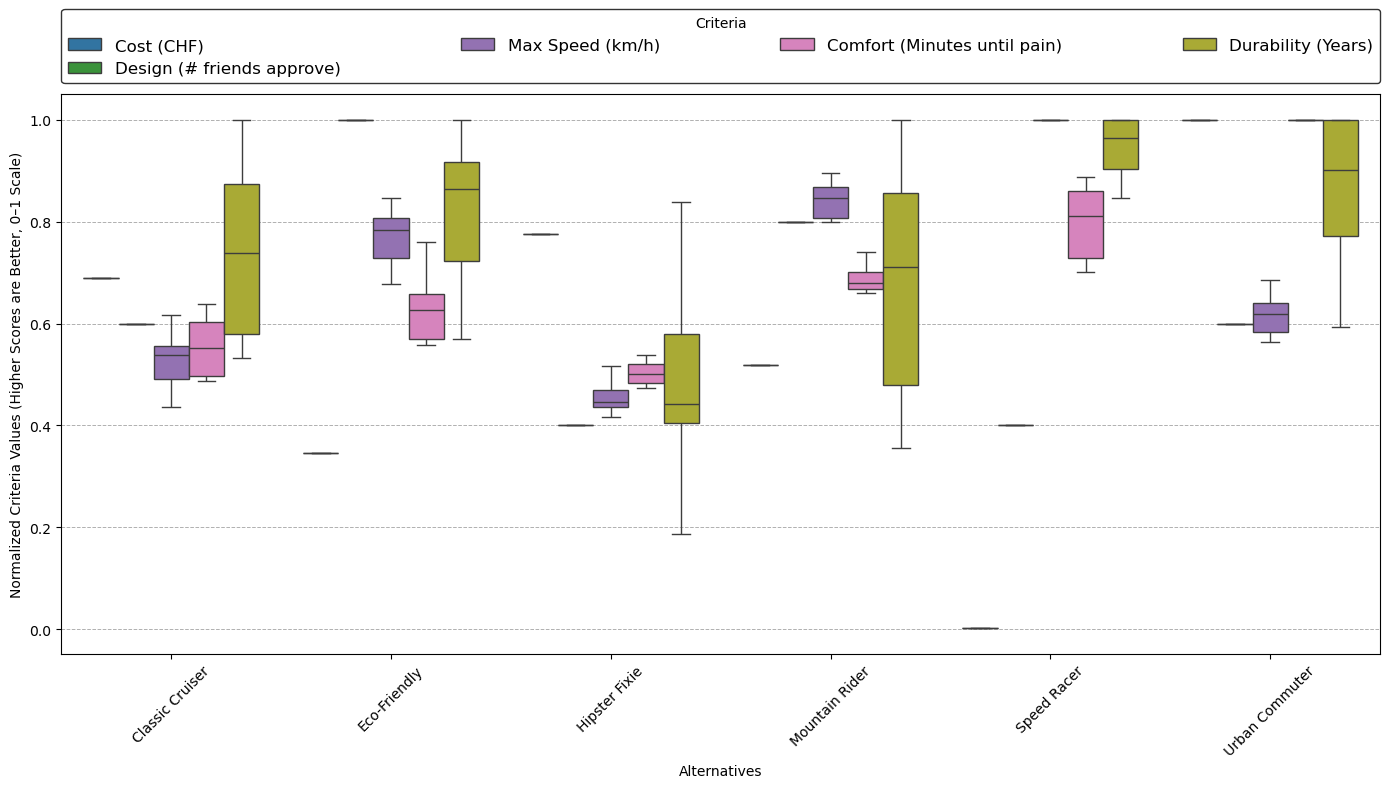

The normalized DataFrame as tabular data:
+----+----------------+-----------------+----------+---------+-----------+-----------+-----------------+-----------------------+----------------------------+---------------------+------------------------------+---------------------+
|    | Alternative ID |      Bike       | Group ID | Source  | Sample ID | SSP Level | Future Location |      Cost (CHF)       | Design (# friends approve) |  Max Speed (km/h)   | Comfort (Minutes until pain) | Durability (Years)  |
+----+----------------+-----------------+----------+---------+-----------+-----------+-----------------+-----------------------+----------------------------+---------------------+------------------------------+---------------------+
| 0  |       A1       | Classic Cruiser |    G1    | Reviews |    S1     |   SSP1    |      Rural      |  0.6901893075753018   |     0.5999898387328981     | 0.5678170745285883  |      0.5285057504389786      | 0.6071433343284973  |
| 1  |       A2       |  E

In [19]:
norm_df = dm_unc.process_and_plot_norm_criteria()

# Display the normalized DataFrame as tabular data
print('The normalized DataFrame as tabular data:')
print(tb.tabulate(norm_df, headers='keys', tablefmt='pretty'))

How does the alternatives performa across samaple ids and groups

In [20]:
dm_unc.calc_rankings(**rank_params).print_rankings()

Group: G1, State: S1
-----------------------------------
+------------------+-----------------+----------+-------------+-------------------+----------+-------+---------+------------+
| Alternative ID   | Bike            | Source   | SSP Level   | Future Location   |   Topsis |   Saw |   Vikor |   copeland |
|------------------+-----------------+----------+-------------+-------------------+----------+-------+---------+------------|
| A1               | Classic Cruiser | Reviews  | SSP1        | Rural             |        4 |     3 |       4 |          3 |
| A2               | Eco-Friendly    | Reviews  | SSP1        | Rural             |        5 |     4 |       3 |          4 |
| A3               | Hipster Fixie   | Reviews  | SSP1        | Rural             |        3 |     5 |       5 |          5 |
| A4               | Mountain Rider  | Reviews  | SSP1        | Rural             |        2 |     2 |       2 |          2 |
| A5               | Speed Racer     | Reviews  | SSP1       

#### 4.3 Evaluate the Probability of Performance for an Alternative

When selecting an alternative, two critical questions arise:

- **Given that we choose Alternative X, what is the probability it achieves a top rank?**
- **Is there a likelihood that it performs poorly?**

To address these questions, we can generate samples from stochastic variables and evaluate the rank distribution across different sample IDs for each alternative across all uncertainty samples. This allows us to assess the likelihood of an alternative achieving a specific rank (e.g., 1st, 2nd, etc.). The number of samples corresponds to the stochastic distribution they are generated from.

*Note 1: This approach is particularly powerful when paired with the CLIMADA **UNSEQUA** module, where a large number of samples are generated from a multivariate stochastic distribution. By analyzing rank distributions across these samples, we can identify the robustness of each alternative under varying scenarios.*

*Note 2: For the simple example above, we only have four unique samples. The distribution is represented by sample IDs and found in the attribute `unc_smpls_df`:*

| **Sample ID** | **SSP Level** | **Future Location** |
|---------------|---------------|---------------------|
| S1            | SSP1          | Rural              |
| S2            | SSP1          | Urban              |
| S3            | SSP5          | Rural              |
| S4            | SSP5          | Urban              |


Cost (CHF): All columns have the same values. Retain the original name.
Design (# friends approve): All columns have the same values. Retain the original name.
Max Speed (km/h): Columns have different values. Reweight and introduce new criteria.
Comfort (Minutes until pain): Columns have different values. Reweight and introduce new criteria.
Durability (Years): Columns have different values. Reweight and introduce new criteria.


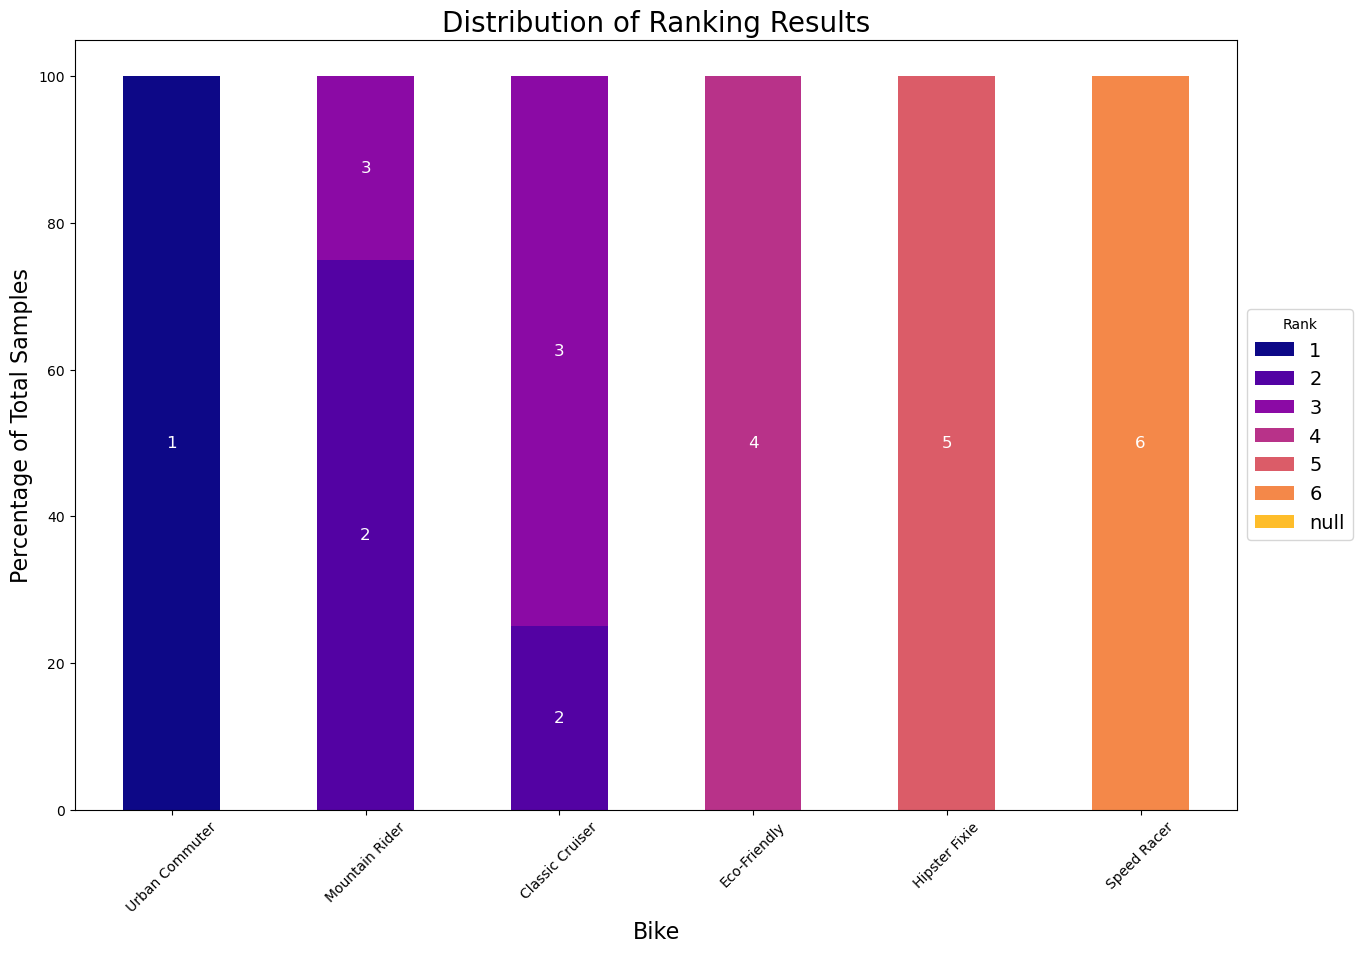

In [21]:
# First pivot the DataFrame and reweight the criteria and then rank the alternatives and plot the rankings
dm_unc.pivot_and_reweight_criteria(piv_col= "Source").calc_rankings().plot_rank_distribution(disp_rnk_col='copeland', alt_name_col = 'Bike')

## 5 Advanced settings 

### 5.1 Advanced Ranking Settings

The MCDM implementation leverages the flexibility of the [pyrepo-mcda library](https://pyrepo-mcda.readthedocs.io/en/latest/), allowing customization of:

- **MCDM Methods**: Choose specific algorithms.
- **Normalization Techniques**: Scale criteria values for comparability.
- **Distance Metrics**: Measure proximity to ideal solutions.

Default settings use preconfigured parameters from the library. Users can also:

- Define custom methods with tailored normalization and distance metrics.
- Combine multiple MCDM methods for compromise rankings.

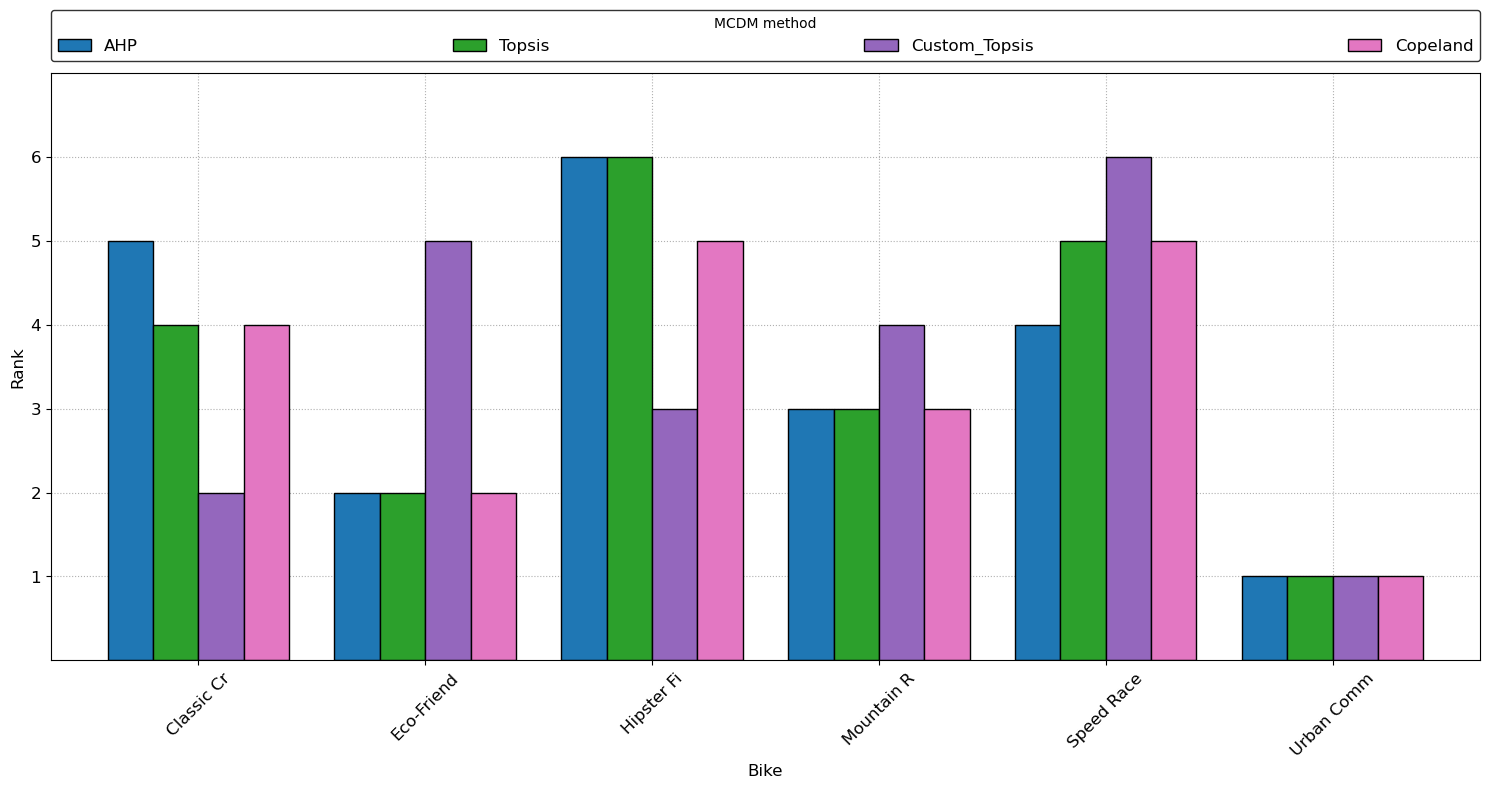

In [22]:
# Define the MCDM ranking methods
from pyrepo_mcda.mcda_methods import AHP, TOPSIS, SAW, VIKOR #  SPOTIS, ARAS, COCOSO, CODAS, COPRAS, CRADIS, EDAS, MABAC, MARCOS, MULTIMOORA, MULTIMOORA_RS, PROMETHEE_II, PROSA_C,, VMCM, WASPAS, VIKOR_SMAA
from pyrepo_mcda.compromise_rankings import copeland, dominance_directed_graph, rank_position_method
from pyrepo_mcda import distance_metrics as dists
from pyrepo_mcda import normalizations as norms


# Define the MCDM ranking methods
mcdm_methods = { 'AHP': AHP(), # Analytic Hierarchy Process default parameters
            'Topsis': TOPSIS(), # Technique for Order Preference by Similarity to Ideal Solution default parameters
            'Custom_Topsis': TOPSIS(normalization_method = norms.sum_normalization, distance_metric = dists.euclidean) # Custom method with customized normalization and distance methdods
    }
# Define the compromised ranking function of the rank matrices
comp_ranks = {'Copeland': copeland,
      }

# Calculate the rankings and plot the results
dm.calc_rankings(**rank_params, mcdm_methods=mcdm_methods, comp_ranks=comp_ranks).plot_ranks()

### 5.2 Normalization Settings

Normalization is a critical step in MCDM, ensuring criteria values from different units or scales are brought to a common range for meaningful comparisons.

In the **CLIMADA MCDM module**, preprocessing ensures consistency before normalization:

1. **Preprocessing for Consistency**:
   - **Negative Values**: Negative values are shifted to start from zero by adding the smallest value plus one.
   - **Minimization Objectives**: Minimized criteria (e.g., cost) are flipped by multiplying by -1 and then shifted to positive, aligning them with maximization objectives. Objective types are updated to "maximize."

   **Note**: These preprocessing steps ensure fairness across criteria and simplify the application of normalization methods. As a result, different normalization methods often produce similar trends, reducing their overall impact on the final rankings.

2. **Normalization Methods**:
   - After preprocessing, values are normalized using methods like:
     - **Linear Normalization**: Spreads values proportionally between 0 and 1.
     - **Max Normalization**: Divides by the maximum, ensuring the highest value becomes 1.
     - **Sum Normalization**: Divides by the total sum, emphasizing relative contributions.
     - **Vector Normalization**: Scales based on magnitude relative to the sum of squares.

---

**Choosing Normalization Methods**:

In CLIMADA the default is *Linear Normalization* as it is easy to understand.

- **Relative Performance**: Highlights how each alternative compares within a criterion.
- **Distribution Impact**:
  - **Linear Distance**: Assumes evenly spaced normalized values.
  - **Proportional Scaling**: Reflects relative contributions to totals or maximums.
  - **Magnitude Scaling**: Retains variance while normalizing.

| **Normalization Method**     | **Description**                                                                                   | **Formula**                                                                                       |
|-------------------------------|---------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Linear Normalization**      | Proportional scaling between 0 and 1. The worst value is 0, the best is 1.                       | $ \text{Value} = \frac{\text{Original} - \text{Min}}{\text{Max} - \text{Min}} $                  |
| **Sum Normalization**         | Divides each value by the sum of all values, highlighting relative contributions.                | $ \text{Value} = \frac{\text{Original}}{\text{Sum of All Values}} $                              |
| **Vector Normalization**      | Scales by magnitude relative to the sum of squares.                                              | $ \text{Value} = \frac{\text{Original}}{\sqrt{\sum (\text{Original Values})^2}} $                |

---

**Implication for Users**:
Preprocessing ensures all criteria are consistently scaled, regardless of their original range or whether they need to be minimized or maximized. This enables fair and straightforward comparisons across alternatives. Moreover, due to the preprocessing steps, the choice of normalization method often has limited influence on overall decision-making trends.


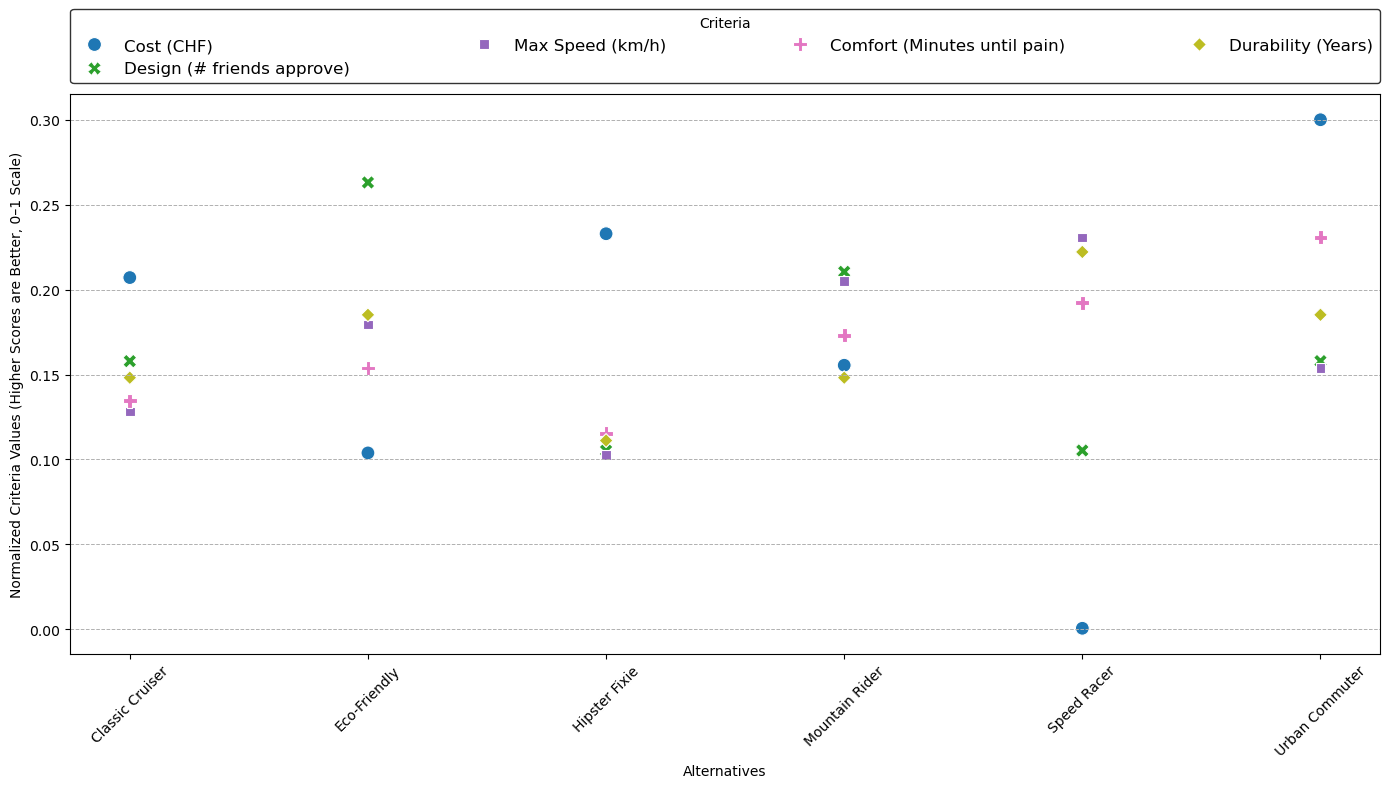

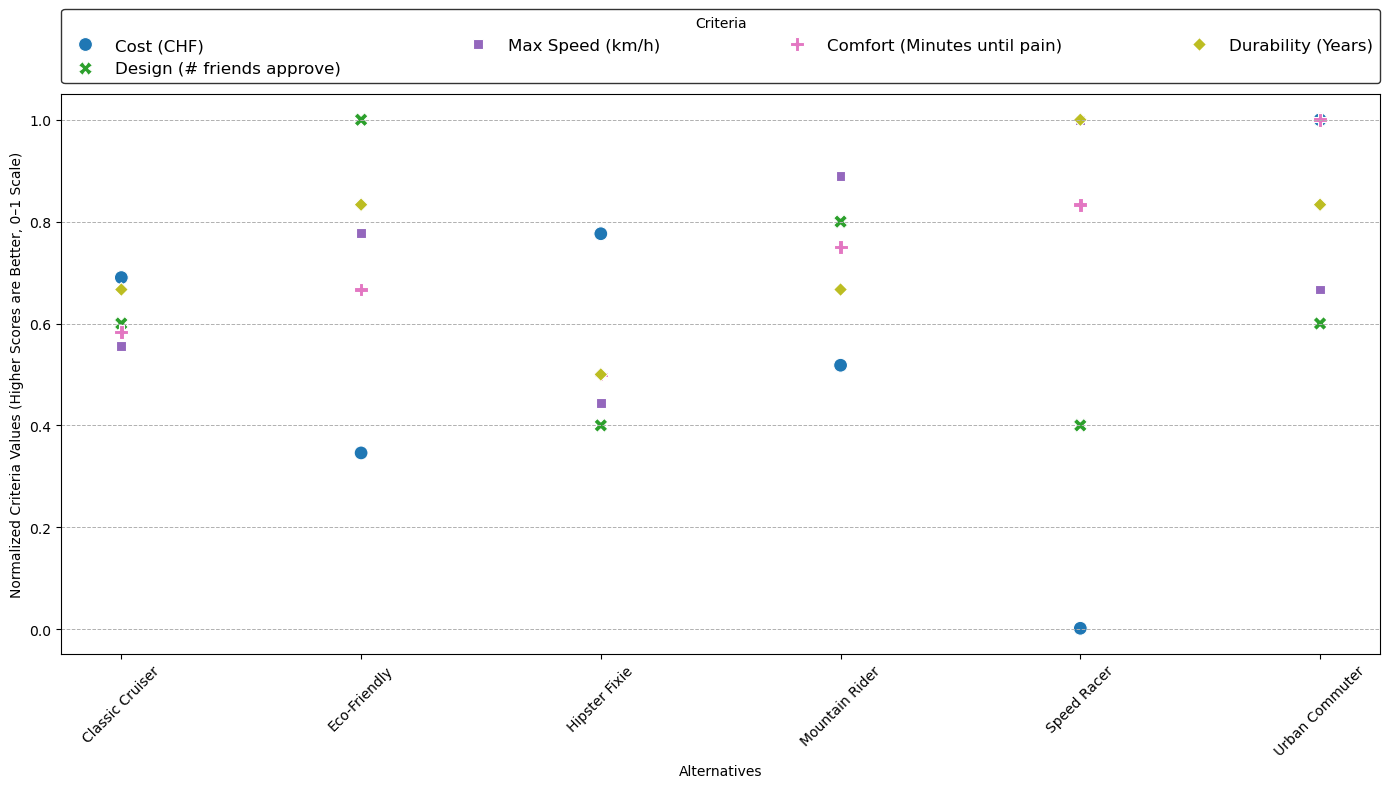

,Alternative ID,Bike,Cost (CHF),Design (# friends approve),Max Speed (km/h),Comfort (Minutes until pain),Durability (Years),Group ID,Sample ID
0,A1,Classic Cruiser,0.690189,0.600013,0.555556,0.583333,0.666668,G1,S1
1,A2,Eco-Friendly,0.345955,1.000000,0.777778,0.666668,0.833333,G1,S1
2,A3,Hipster Fixie,0.776248,0.400005,0.444445,0.500000,0.500010,G1,S1
3,A4,Mountain Rider,0.518072,0.800016,0.888890,0.750001,0.666668,G1,S1
4,A5,Speed Racer,0.001721,0.400018,1.000000,0.833333,1.000000,G1,S1
5,A6,Urban Commuter,1.000000,0.600003,0.666668,1.000000,0.833345,G1,S1


In [23]:
dm.process_and_plot_norm_criteria(norm_func=norms.sum_normalization)
dm.process_and_plot_norm_criteria()


4. **Distance Metrics (Advanced Option)**
   - Some methods, such as TOPSIS, rely on calculating distances from ideal and non-ideal solutions (e.g., using Euclidean distance).
